In [1]:
import random
import sys
import warnings
from pathlib import Path

import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch  # cheap way to check GPU availability
import xarray as xr
from catboost import CatBoostRegressor, Pool
from matplotlib.colors import BoundaryNorm

# Evaluate model performance
from sklearn.model_selection import train_test_split

# Add parent directory to Python path to access src modules
sys.path.append(str(Path("..").resolve()))
from src.utils.logger import setup_logger

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
# Set random seed for reproducibility
random.seed(42)
logger = setup_logger(name="CatboostTraining", log_file="../logs/notebooks/catboost.log")


def find_valid_gauges(e_obs_ws: gpd.GeoDataFrame, hydro_dir: Path) -> tuple[list[str], list[str]]:
    """Find gauges with valid hydro data (no missing values).

    Args:
        e_obs_ws: GeoDataFrame with watershed information
        hydro_dir: Path to directory containing hydro data files

    Returns:
        tuple: (full_gauges, partial_gauges)
            - full_gauges: List of gauge IDs with complete data
            - partial_gauges: List of gauge IDs with some missing values
    """
    full_gauges = []
    partial_gauges = []

    for gauge_id in e_obs_ws.index:
        hydro_file = pd.read_csv(f"{hydro_dir}/{gauge_id}.csv", parse_dates=["date"], index_col="date")[
            ["q_mm_day"]
        ]
        is_completely_nan = hydro_file["q_mm_day"].isna().all()
        if is_completely_nan:
            pass
        elif hydro_file["q_mm_day"].isna().sum() > 0:
            partial_gauges.append(gauge_id)
        else:
            full_gauges.append(gauge_id)
    logger.info(
        f"Found {len(full_gauges)} gauges with complete data and {len(partial_gauges)} with partial data"
    )
    return full_gauges, partial_gauges


def select_uncorrelated_features(
    data: pd.DataFrame, threshold: float = 0.7, min_valid_fraction: float = 0.8
) -> list[str]:
    """Select features from the DataFrame that are not highly correlated, have sufficient valid data, and do not contain '_cl_' in their names.

    Args:
        data: Input DataFrame with features.
        threshold: Absolute correlation threshold above which features are considered correlated.
        min_valid_fraction: Minimum fraction of non-zero and non-NaN values required to keep a feature.

    Returns:
        List of column names representing uncorrelated features with sufficient valid data and without '_cl_' in their names.
    """
    # Exclude columns containing '_cl_' in their names
    filtered_cols = [col for col in data.columns if "_cl_" not in col]
    filtered_data = data[filtered_cols]

    # Filter out columns with less than min_valid_fraction valid (non-zero, non-NaN) data
    valid_mask = (filtered_data != 0) & (~filtered_data.isna())
    valid_fraction = valid_mask.sum(axis=0) / len(filtered_data)
    sufficient_data_cols = valid_fraction[valid_fraction >= min_valid_fraction].index.tolist()

    # Subset data to columns with sufficient valid data
    filtered_data = filtered_data[sufficient_data_cols]

    # Compute the absolute correlation matrix
    corr_matrix = filtered_data.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify columns to drop based on correlation threshold
    to_drop = set()
    for col in upper.columns:
        if any(upper[col] > threshold):
            to_drop.add(col)

    # Features to keep are those not in to_drop
    selected_features = [col for col in filtered_data.columns if col not in to_drop]
    return selected_features


# Define constants for file paths and directories
METEO_DIR = Path("../data/MeteoData/ProcessedGauges/meteo_ru_nc_02/res/")
HYDRO_DIR = Path("../data/HydroFiles/")

LAGS = [2**n for n in range(6)]  # 1,2,4,8,16,32
ROLL_MEAN = ["t_min", "t_max"]


def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    """Add lagged features for precipitation and temperature variables.

    Creates rolling sum for precipitation and rolling mean for temperature
    variables using predefined lags in LAGS list.

    Args:
        df: DataFrame containing 'prcp' and temperature columns defined in ROLL_MEAN

    Returns:
        DataFrame with additional lagged features
    """
    for d in LAGS:
        df[f"prcp_{d}"] = df["prcp"].rolling(d, min_periods=1).sum()
        for v in ROLL_MEAN:
            df[f"{v}_mean_{d}"] = df[v].rolling(d, min_periods=1).mean()
    return df


def load_one_site(gid: str) -> pd.DataFrame:
    """Load meteorological and hydrological data for a specific gauge.

    Reads NetCDF meteorological data and CSV hydrological data for the
    specified gauge ID and merges them based on date.

    Args:
        gid: Gauge ID string

    Returns:
        DataFrame containing merged meteorological and hydrological data
    """
    # --- dynamic meteo ---
    ds = xr.open_dataset(f"{METEO_DIR}/{gid}.nc")
    meteo = ds.to_dataframe().reset_index()  # date index -> column
    # --- dynamic hydro target ---
    q = pd.read_csv(f"{HYDRO_DIR}/{gid}.csv", parse_dates=["date"]).rename(columns={"q_mm_day": "q"})
    # --- merge & add site id ---
    df = meteo.merge(q, on="date", how="inner")
    df["gauge_id"] = gid
    return df


def data_creator(
    full_gauges: list[str],
    static_data: pd.DataFrame,
) -> pd.DataFrame:
    """Create a DataFrame with static and dynamic features.

    Args:
        full_gauges: List of gauge IDs to include in the dataset
        static_data: DataFrame with static features

    Returns:
        DataFrame with static and dynamic features, indexed by date and gauge ID
    """
    pool = []
    for gid in full_gauges:
        pool.append(load_one_site(gid))

    dynamic = pd.concat(pool, ignore_index=True)
    dynamic = (
        dynamic.groupby("gauge_id", group_keys=False)
        .apply(add_lags)
        .dropna(subset=[f"prcp_{max(LAGS)}"])  # avoid warm-up NaNs
    )
    # Merge static and dynamic data
    if "gauge_id" not in static_data.columns:
        static_data = static_data.reset_index()

    merged = dynamic.merge(static_data, on="gauge_id", how="left")
    # Select only specified features and target
    return merged


def log_improved_results(study: optuna.Study, trial: optuna.trial.FrozenTrial) -> None:
    """Optuna callback to log results only when a better metric is found.

    Args:
        study (optuna.Study): The current Optuna study.
        trial (optuna.trial.FrozenTrial): The most recent finished trial.

    Returns:
        None
    """
    # Only log when the current trial is the best so far
    if study.best_trial.number == trial.number:
        logger.info(
            f"Trial {trial.number + 1}: New best KGE = {trial.value:.3f} (params: {trial.params})"
        )


In [2]:
# Read watershed and gauge geometry data from GeoPackage files
e_obs_ws = gpd.read_file("../data/Geometry/EOBSWatersheds2025.gpkg", ignore_geometry=False)
e_obs_ws.set_index("gauge_id", inplace=True)
e_obs_gauge = gpd.read_file("../data/Geometry/EOBSPoints2025.gpkg", ignore_geometry=False)
e_obs_gauge.set_index("gauge_id", inplace=True)
# Find valid gauges (no missing data)
logger.info("Finding gauges with valid data...")
full_gauges, partial_gauges = find_valid_gauges(e_obs_ws, Path("../data/HydroFiles"))
static_data = pd.read_csv(
    "../data/Geometry/static_data.csv", dtype={"gauge_id": str}, index_col="gauge_id"
)
static_data = static_data.loc[full_gauges, :]

# Get uncorrelated features from static_data
uncorrelated_static_features = select_uncorrelated_features(static_data)
old_static_features = [
    "for_pc_sse",
    "crp_pc_sse",
    "inu_pc_ult",
    "ire_pc_sse",
    "lka_pc_use",
    "prm_pc_sse",
    "pst_pc_sse",
    "cly_pc_sav",
    "slt_pc_sav",
    "snd_pc_sav",
    "kar_pc_sse",
    "urb_pc_sse",
    "gwt_cm_sav",
    "lkv_mc_usu",
    "rev_mc_usu",
    "sgr_dk_sav",
    "slp_dg_sav",
    "ws_area",
    "ele_mt_sav",
]

combined_feature = list(set(old_static_features + uncorrelated_static_features))
static_data_uncorr = static_data[uncorrelated_static_features]
my_features = static_data[old_static_features]
combined_features = static_data[combined_feature]
logger.info(f"Selected {len(uncorrelated_static_features)} uncorrelated features from static_data.")


2025-06-21 12:42:18 | CatboostTraining | INFO     | <module>:7 | Finding gauges with valid data...
2025-06-21 12:42:20 | CatboostTraining | INFO     | find_valid_gauges:58 | Found 302 gauges with complete data and 245 with partial data
2025-06-21 12:42:20 | CatboostTraining | INFO     | <module>:42 | Selected 15 uncorrelated features from static_data.


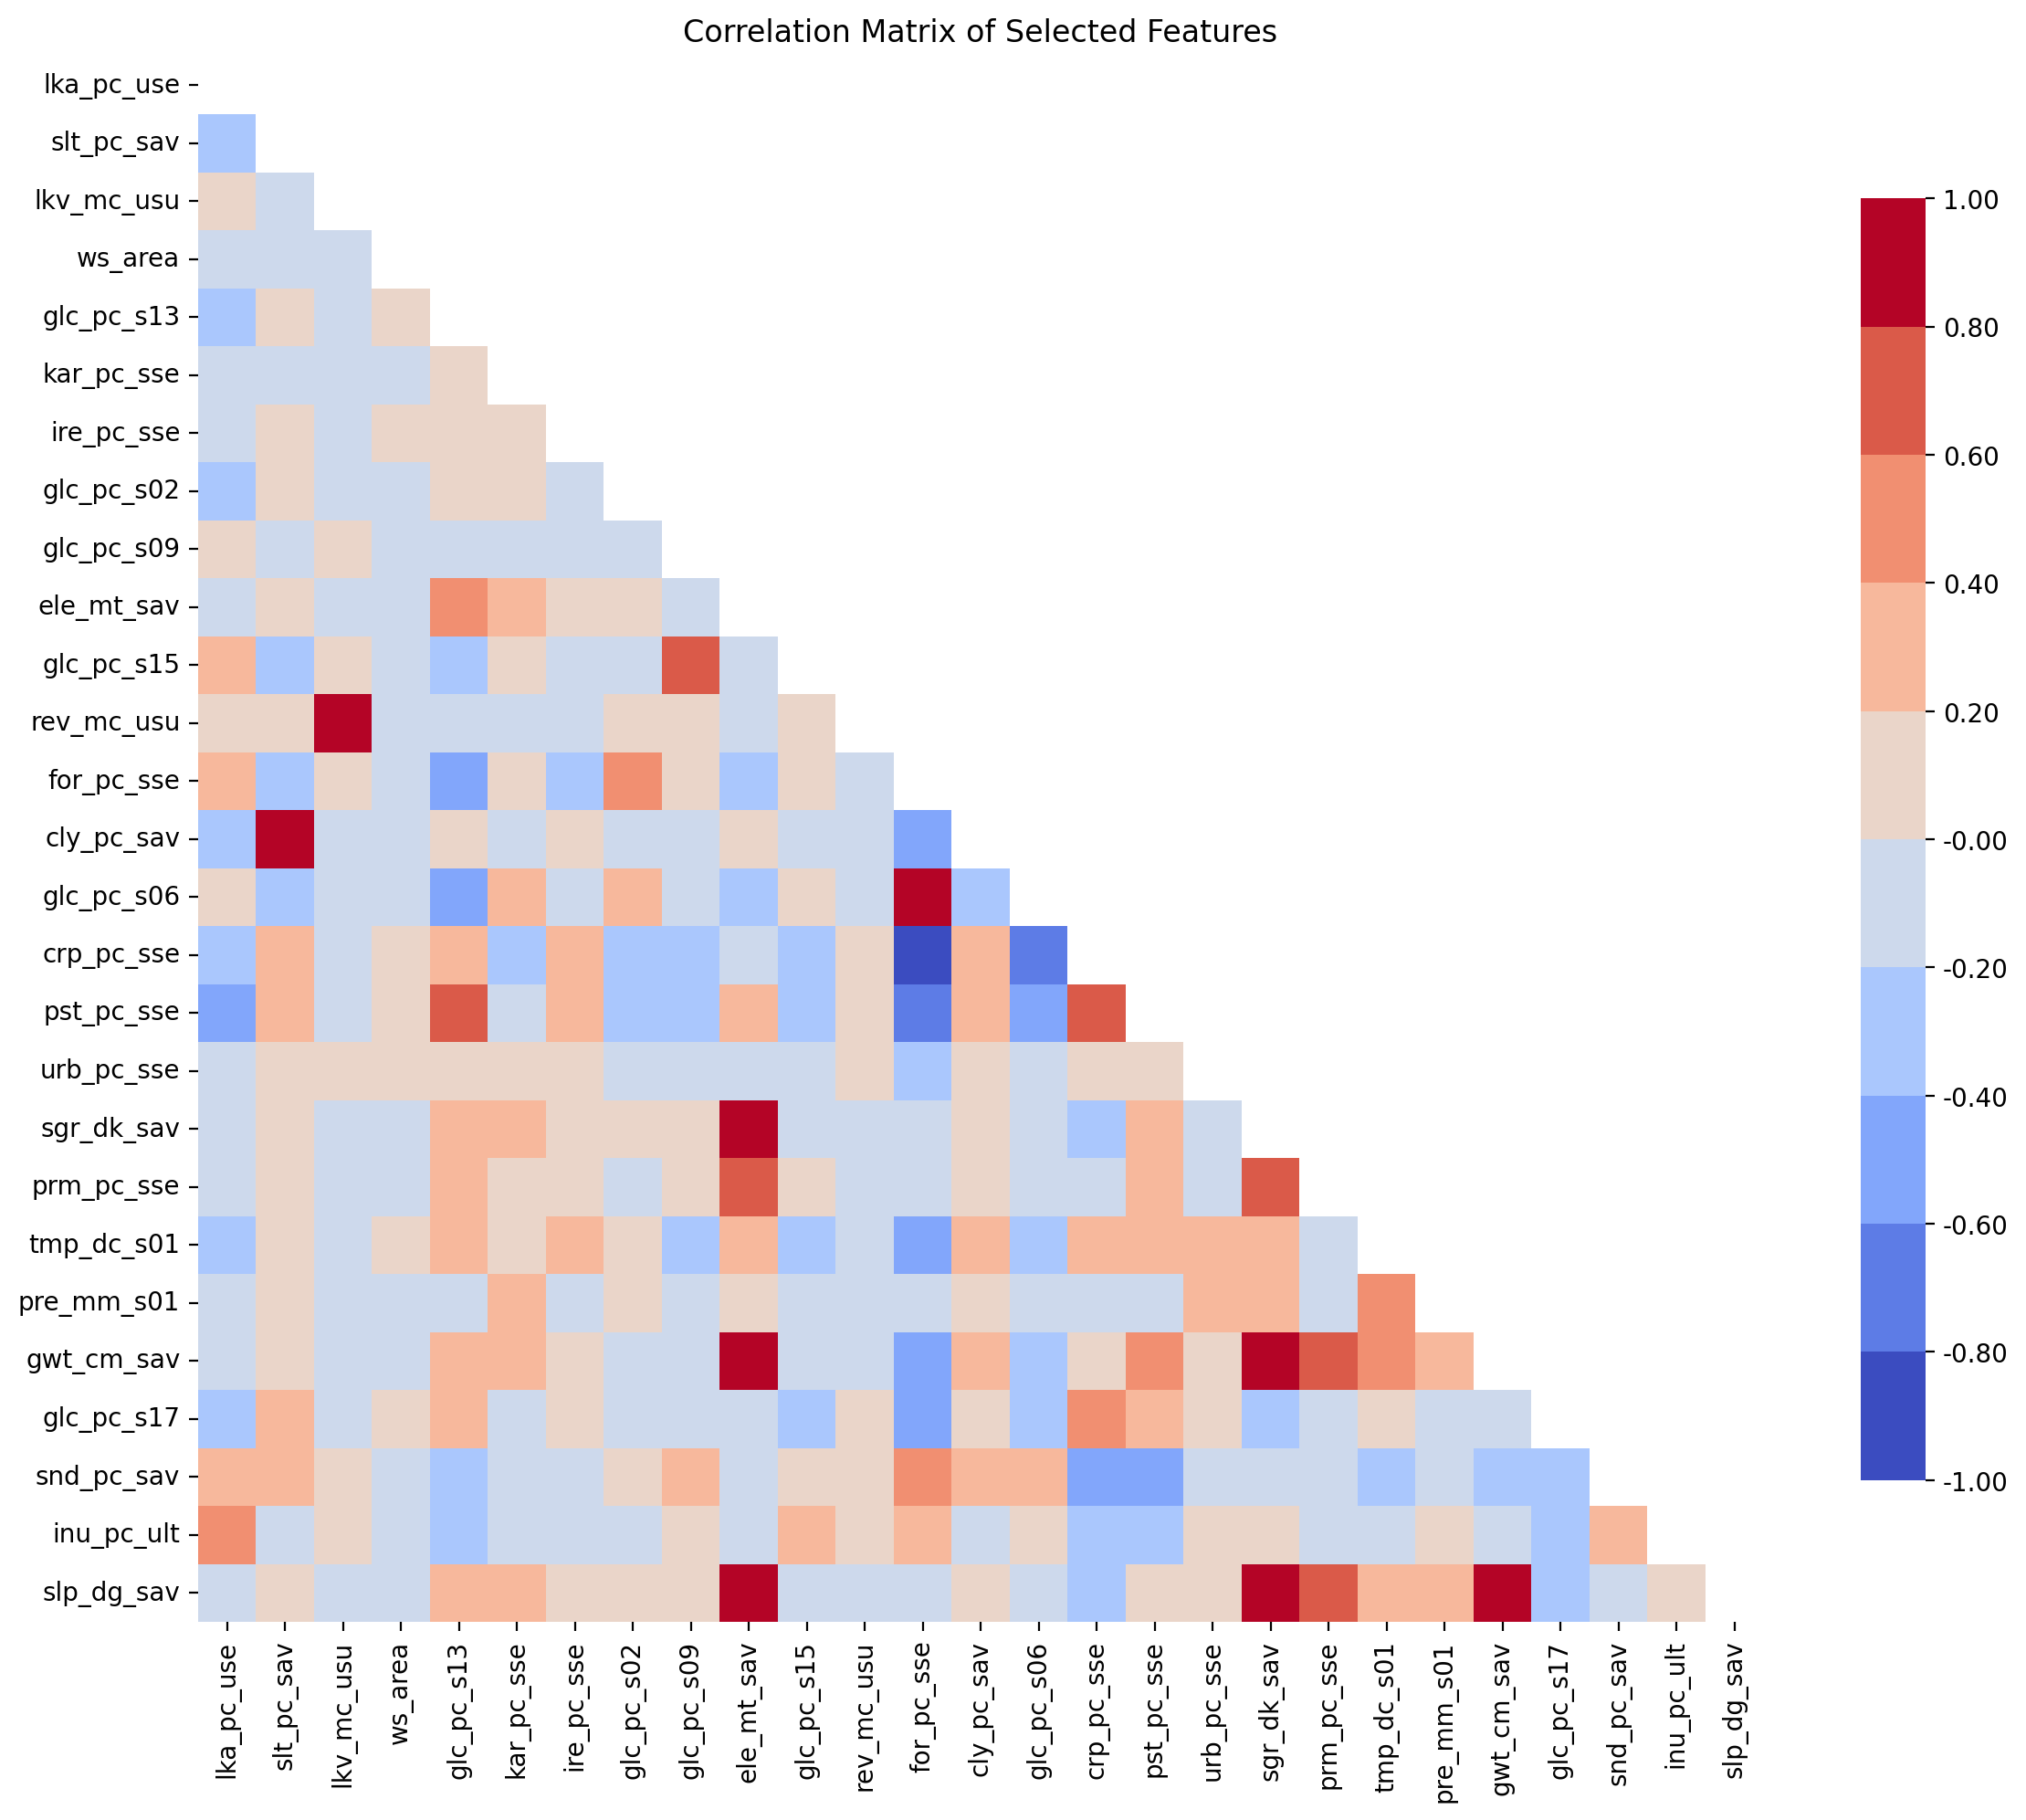

In [3]:
# Create discrete colormap
correlation_matrix = combined_features.corr()

# Create heatmap with discrete colorbar
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a larger figure for better visibility
plt.figure(figsize=(12, 10))

# Define discrete color levels for the colorbar with 0.2 intervals
levels = np.arange(-1, 1.2, 0.2)  # -1.0 to 1.0 in steps of 0.2

# Create a discrete colormap with boundaries
cmap = cm.coolwarm
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Create heatmap with discrete colormap
ax = sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=False,
    cmap=cmap,
    norm=norm,
    center=0,
    square=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.8, "boundaries": levels, "ticks": levels},
    vmin=-1,
    vmax=1,
)

# Set discrete tick labels on colorbar
cbar = ax.collections[0].colorbar
cbar.set_ticks(levels)
cbar.set_ticklabels([f"{level:.2f}" for level in levels])

plt.title("Correlation Matrix of Selected Features")
plt.tight_layout()
plt.show()


In [4]:
# Reset index of combined_features to prepare for merging
combined_features = combined_features.reset_index()
# Split full_gauges into train (80%) and test (20%) sets
train_gauges, test_gauges = train_test_split(full_gauges, test_size=0.15, random_state=42)

logger.info(
    f"Split {len(full_gauges)} gauges into {len(train_gauges)} train and {len(test_gauges)} test gauges"
)
logger.info(f"Train gauges: {len(train_gauges)} samples")
logger.info(f"Test gauges: {len(test_gauges)} samples")
# Log dataset creation
logger.info(f"Creating training dataset with {len(train_gauges)} gauges...")
data = data_creator(full_gauges=train_gauges, static_data=combined_features)
logger.info(f"Creating test dataset with {len(test_gauges)} gauges...")
new_data = data_creator(full_gauges=test_gauges, static_data=combined_features)

# Define date ranges for train and validation sets
logger.info("Splitting data into training and validation periods...")
train_mask = ("2008-01-01" <= data["date"]) & (data["date"] <= "2020-12-31")
valid_mask = ("2021-01-01" <= data["date"]) & (data["date"] <= "2022-12-31")

# Verify we have data in both splits
train_count = train_mask.sum()
valid_count = valid_mask.sum()
logger.info(f"Training samples: {train_count}, Validation samples: {valid_count}")

# Define features
CATS = ["gauge_id"]  # Categorical features
EXCLUDED_COLS = ["date", "q", "q_cms", "lvl_sm", "lvl_mbs"]
FEATURES = [c for c in data.columns if c not in EXCLUDED_COLS]

# Get indices for efficient slicing
train_idx = data[train_mask].index
valid_idx = data[valid_mask].index

# Create CatBoost pools
train_pool = Pool(data.iloc[train_idx][FEATURES], label=data.iloc[train_idx]["q"], cat_features=CATS)
valid_pool = Pool(data.iloc[valid_idx][FEATURES], label=data.iloc[valid_idx]["q"], cat_features=CATS)

logger.info(f"Prepared {len(FEATURES)} features with {len(CATS)} categorical features")

2025-06-16 16:26:51 | CatboostTraining | INFO     | <module>:6 | Split 335 gauges into 284 train and 51 test gauges
2025-06-16 16:26:51 | CatboostTraining | INFO     | <module>:9 | Train gauges: 284 samples
2025-06-16 16:26:51 | CatboostTraining | INFO     | <module>:10 | Test gauges: 51 samples
2025-06-16 16:26:51 | CatboostTraining | INFO     | <module>:12 | Creating training dataset with 284 gauges...
2025-06-16 16:26:56 | CatboostTraining | INFO     | <module>:14 | Creating test dataset with 51 gauges...
2025-06-16 16:26:57 | CatboostTraining | INFO     | <module>:18 | Splitting data into training and validation periods...
2025-06-16 16:26:57 | CatboostTraining | INFO     | <module>:25 | Training samples: 1335204, Validation samples: 202940
2025-06-16 16:26:57 | CatboostTraining | INFO     | <module>:40 | Prepared 51 features with 1 categorical features


In [5]:
# ------------------------------------------------------------------ #
# 1. Metric                                                           #
# ------------------------------------------------------------------ #
def kge(y_true, y_pred):
    """Calculate Kling-Gupta Efficiency (KGE).

    Args:
        y_true: Array of observed values
        y_pred: Array of predicted values

    Returns:
        float: KGE score (higher is better)
    """
    r = np.corrcoef(y_true, y_pred)[0, 1]
    alpha = np.std(y_pred) / np.std(y_true)
    beta = np.mean(y_pred) / np.mean(y_true)
    return 1.0 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)


GPU_OK = torch.cuda.is_available()


# ------------------------------------------------------------------ #
# 2. Optuna objective                                                 #
# ------------------------------------------------------------------ #
def objective(trial: optuna.Trial) -> float:
    """Optimization objective for Optuna.

    Args:
        trial: Optuna trial object

    Returns:
        float: KGE score to maximize
    """
    # ---------- generic knobs -------------------------------------- #
    params = {
        "iterations": trial.suggest_int("iterations", 500, 10000, step=250),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 32),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "early_stopping_rounds": 80,
        "verbose": 0,
        "random_seed": 42,
        "task_type": "GPU" if GPU_OK else "CPU",
        "gpu_ram_part": 0.95 if GPU_OK else None,
    }

    # ---------- grow-policy block ---------------------------------- #
    grow_policy = trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"])
    params["grow_policy"] = grow_policy

    if grow_policy != "Lossguide":
        params["depth"] = trial.suggest_int("depth", 4, 10)
    else:
        # keep trees shallow; CatBoost will infer reasonable default if omitted
        params["max_depth"] = trial.suggest_int("max_depth", 6, 12)

    # ---------- bootstrap block ------------------------------------ #
    bootstrap_type = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    params["bootstrap_type"] = bootstrap_type

    # Only add bagging_temperature for Bayesian bootstrap type
    if bootstrap_type == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif bootstrap_type == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)
    else:  # MVS
        params["mvs_reg"] = trial.suggest_float("mvs_reg", 0.1, 5.0)

    # ---------- model fit ------------------------------------------ #
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    y_val_pred = model.predict(valid_pool)
    return kge(valid_pool.get_label(), y_val_pred)


# ------------------------------------------------------------------ #
# 3. Study                                                            #
# ------------------------------------------------------------------ #
study = optuna.create_study(
    study_name="catboost_kge_clean",
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=20, n_warmup_steps=40),
)
study.optimize(objective, n_trials=150, show_progress_bar=True, callbacks=[log_improved_results])

logger.info(f"Best KGE = {study.best_value:.3f}")
logger.info(f"Best params: {study.best_params}")


  0%|          | 0/150 [00:00<?, ?it/s]

2025-06-16 16:27:33 | CatboostTraining | INFO     | log_improved_results:200 | Trial 1: New best KGE = 0.788 (params: {'iterations': 4000, 'learning_rate': 0.2536999076681772, 'l2_leaf_reg': 5.395030966670228, 'random_strength': 0.0024430162614261413, 'min_data_in_leaf': 5, 'border_count': 66, 'grow_policy': 'Depthwise', 'depth': 8, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6061695553391381})
2025-06-16 16:27:56 | CatboostTraining | INFO     | log_improved_results:200 | Trial 2: New best KGE = 0.788 (params: {'iterations': 2250, 'learning_rate': 0.018659959624904916, 'l2_leaf_reg': 2.0148477884158655, 'random_strength': 0.00052821153945323, 'min_data_in_leaf': 14, 'border_count': 97, 'grow_policy': 'SymmetricTree', 'depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7571172192068059})
2025-06-16 16:29:34 | CatboostTraining | INFO     | log_improved_results:200 | Trial 10: New best KGE = 0.797 (params: {'iterations': 8250, 'learning_rate': 0.18681142751959703, 'l2_leaf_reg': 1

: 

In [ ]:
def objective(trial):
    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]
        ),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Plain", "Ordered"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "verbose": 0,
    }

    model = CatBoostRegressor(**params)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

    y_pred = model.predict(X_val)
    return -kge(y_val, y_pred)  # or -nse(y_val, y_pred)


# Run Optuna optimization
study = optuna.create_study(direction="minimize")


def log_improved_results(study: optuna.Study, trial: optuna.trial.FrozenTrial) -> None:
    """Optuna callback to log results only when a better metric is found.

    Args:
        study (optuna.Study): The current Optuna study.
        trial (optuna.trial.FrozenTrial): The most recent finished trial.

    Returns:
        None
    """
    # Only log when the current trial is the best so far
    if study.best_trial.number == trial.number:
        logger.info(
            f"Trial {trial.number + 1}: New best MAPE = {trial.value:.3f} (params: {trial.params})"
        )


# Add pruning mechanism to stop unpromising trials early
pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=30)
study = optuna.create_study(direction="minimize", pruner=pruner)

# Reduced number of trials for faster results, but still sufficient for good optimization
study.optimize(objective, n_trials=200, show_progress_bar=True, callbacks=[log_improved_results])
best_params = study.best_params

# Log best parameters and score
logger.info(f"Best MAPE: {study.best_value:.4f}")
logger.info(f"Best parameters: {best_params}")

In [18]:
# Add final configuration parameters to the best parameters found
best_params.update(
    {
        "loss_function": "MAPE",
        "iterations": 10_000,  # Use more iterations for final model
        "early_stopping_rounds": 300,
        "random_seed": 42,
        "verbose": 100,  # Show progress every 100 iterations
        "grow_policy": "Lossguide",  # Use Lossguide for better handling of large
        "task_type": "GPU",
        "gpu_ram_part": 0.95,  # Utilize 95% of available GPU memory
    }
)

# Train final model
logger.info("Training final model with best parameters...")
final_model = CatBoostRegressor(**best_params)
final_model.fit(Pool(new_data[FEATURES], label=new_data["q"], cat_features=CATS))


2025-06-16 15:32:14 | CatboostTraining | INFO     | <module>:16 | Training final model with best parameters...


0:	learn: 0.3069912	total: 4.84ms	remaining: 48.4s
100:	learn: 0.3063692	total: 431ms	remaining: 42.3s
200:	learn: 0.3063693	total: 845ms	remaining: 41.2s
300:	learn: 0.3063693	total: 1.29s	remaining: 41.6s
400:	learn: 0.3063694	total: 1.74s	remaining: 41.8s
500:	learn: 0.3063693	total: 2.2s	remaining: 41.8s
600:	learn: 0.3063694	total: 2.65s	remaining: 41.4s
700:	learn: 0.3063693	total: 3.1s	remaining: 41.1s
800:	learn: 0.3063694	total: 3.56s	remaining: 40.9s
900:	learn: 0.3063693	total: 4.01s	remaining: 40.5s
1000:	learn: 0.3063694	total: 4.46s	remaining: 40.1s
1100:	learn: 0.3063694	total: 4.9s	remaining: 39.6s
1200:	learn: 0.3063693	total: 5.34s	remaining: 39.1s
1300:	learn: 0.3063693	total: 5.78s	remaining: 38.7s
1400:	learn: 0.3063693	total: 6.22s	remaining: 38.2s
1500:	learn: 0.3063694	total: 6.68s	remaining: 37.9s
1600:	learn: 0.3063693	total: 7.15s	remaining: 37.5s
1700:	learn: 0.3063693	total: 7.61s	remaining: 37.1s
1800:	learn: 0.3063694	total: 8.05s	remaining: 36.7s
1900:	l

In [20]:
new_data["q_pred"] = final_model.predict(new_data[FEATURES])

In [ ]:
import plotly.graph_objs as go


def plot_predictions_over_test_gauges(
    df: pd.DataFrame,
    gauge_column: str = "gauge_id",
    date_column: str = "date",
    pred_column: str = "q_pred",
    true_column: str = "q",
) -> None:
    """Plot predicted vs. true values for each test gauge using Plotly.

    Args:
        df (pd.DataFrame): DataFrame containing predictions and true values.
        gauge_column (str): Column name for gauge IDs.
        date_column (str): Column name for dates.
        pred_column (str): Column name for predicted values.
        true_column (str): Column name for true values.

    Returns:
        None
    """
    gauges = df[gauge_column].unique()
    for gid in gauges:
        gauge_df = df[df[gauge_column] == gid].sort_values(date_column)
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(
                x=gauge_df[date_column],
                y=gauge_df[true_column],
                mode="lines",
                name="True Q",
                line=dict(color="royalblue"),
            )
        )
        fig.add_trace(
            go.Scatter(
                x=gauge_df[date_column],
                y=gauge_df[pred_column],
                mode="lines",
                name="Predicted Q",
                line=dict(color="firebrick"),
            )
        )
        fig.update_layout(
            title=f"Predictions vs True for Gauge {gid}",
            xaxis_title="Date",
            yaxis_title="Discharge (q)",
            legend=dict(x=0.01, y=0.99),
            height=400,
            width=900,
        )
        fig.show()


# Plot predictions for all test gauges in new_data
plot_predictions_over_test_gauges(new_data)